# CS492 전산학특강<인공지능 산업 및 스마트에너지>
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

### 5-3. Text classification with an RNN

Let's build text classification model with RNN on the IMDB dataset for sentiment analysis.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow_datasets as tfds
import tensorflow as tf

#### Setup input pipeline

The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

Download the dataset using [`TFDS`](https://www.tensorflow.org/datasets). The dataset comes with an inbuilt subword tokenizer.
- Args of [`tfds.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load):
    - `name`: str, the registered name of the DatasetBuilder.
    - `with_info`: bool, if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) containing the info associated with the builder.
    - `as_supervised`: bool, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False, the default, the returned tf.data.Dataset will have a dictionary with all the features.

In [2]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)

# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

train_dataset, test_dataset = dataset['train'], dataset['test']

W0925 15:04:37.715963 140045249144640 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


As this is a subwords tokenizer, it can be passed any string and the tokenizer will tokenize it.
- Methods of [`tfds.features.text.SubwordTextEncoder`](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder#encode):
    - [`encode`](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder#encode): Encodes text into a list of integers.
    - [`decode`](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder#decode): Decodes a list of integers into text.

In [3]:
tokenizer = info.features['text'].encoder

print ('Vocabulary size: {}'.format(tokenizer.vocab_size))

Vocabulary size: 8185


In [4]:
sample_string = 'TensorFlow is cool.'

# Encode the sample string to integers
tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode the encoded integers to the string 
original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


assert original_string == sample_string

Tokenized string is [6307, 2327, 4043, 4265, 9, 2724, 7975]
The original string: TensorFlow is cool.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [5]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
4265 ----> ow 
9 ----> is 
2724 ----> cool
7975 ----> .


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

[`tf.data.Dataset.padded_batch`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#padded_batch): Combines consecutive elements of this dataset into padded batches.

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

#### Create the model
Build a `tf.keras.Sequential` model and start with an _embedding layer_. An _embedding layer_ stores one vector per word. When called, **it converts the sequences of word indices to sequences of vectors**. **These vectors are trainable**. After training (on enough data), words with similar meanings often have similar vectors.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.


[`tf.keras.layers.LSTM`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM): An LSTM layer with size units=hidden_units.

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM

lstm_model = Sequential([Embedding(tokenizer.vocab_size, 64), 
                         LSTM(64),
                         # Bidirectional(LSTM(64)),
                         Dense(64, activation='relu'),
                         Dense(1, activation='sigmoid')
                        ])


Compile the Keras model to configure the training process:

In [9]:
lstm_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

#### Train the model

In [ ]:
lstm_history = lstm_model.fit(train_dataset, epochs=10,
                              validation_data=test_dataset)

In [11]:
test_loss, test_acc = lstm_model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 25s 64ms/step - loss: 0.6963 - accuracy: 0.5021
Test Loss: 0.6962835910680044
Test Accuracy: 0.5021200180053711


In [12]:
lstm_model.save('lstm_model_10ep.h5')


The [`tf.keras.layers.Bidirectional`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Bidirectional) wrapper can also be used with an RNN layer. This propagates the **input forward and backwards through the RNN layer and then concatenates the output**. This helps the RNN to learn long range dependencies.
- Example of Bidirectonal LSTM model
<img src=https://www.i2tutorials.com/wp-content/uploads/2019/05/Deep-Dive-into-Bidirectional-LSTM-i2tutorials.jpg>

In [17]:
blstm_model = Sequential([Embedding(tokenizer.vocab_size, 64), 
                         Bidirectional(LSTM(64)),
                         Dense(64, activation='relu'),
                         Dense(1, activation='sigmoid')
                        ])

blstm_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

In [18]:
blstm_history = blstm_model.fit(train_dataset, epochs=10,
                              validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 113s 290ms/step - loss: 0.6179 - accuracy: 0.6554 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 109s 278ms/step - loss: 0.5665 - accuracy: 0.7086 - val_loss: 0.5682 - val_accuracy: 0.7605
Epoch 3/10
391/391 [==============================] - 109s 279ms/step - loss: 0.4903 - accuracy: 0.7843 - val_loss: 0.5808 - val_accuracy: 0.7471
Epoch 4/10
391/391 [==============================] - 109s 279ms/step - loss: 0.3750 - accuracy: 0.8487 - val_loss: 0.4467 - val_accuracy: 0.8048
Epoch 5/10
391/391 [==============================] - 109s 280ms/step - loss: 0.3101 - accuracy: 0.8802 - val_loss: 0.4219 - val_accuracy: 0.8159
Epoch 6/10
391/391 [==============================] - 109s 279ms/step - loss: 0.2598 - accuracy: 0.9028 - val_loss: 0.4352 - val_accuracy: 0.8266
Epoch 7/10
391/391 [==============================] - 109s 279ms/step - loss: 0.2157 - accuracy: 0.9196 - val_loss: 

In [19]:
test_loss, test_acc = blstm_model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 36s 93ms/step - loss: 0.5391 - accuracy: 0.8204
Test Loss: 0.5391427963362325
Test Accuracy: 0.8203999996185303


In [20]:
blstm_model.save('blstm_model_10ep.h5')

The above **model does not mask the padding applied to the sequences**. This can lead to skewness if we train on padded sequences and test on un-padded sequences. Ideally the model would learn to ignore the padding, but as you can see below it does have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [21]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [22]:
def sample_predict(sentence, pad):
    tokenized_sample_pred_text = tokenizer.encode(sample_pred_text)

    if pad:
        tokenized_sample_pred_text = pad_to_size(tokenized_sample_pred_text, 64)

    predictions = lstm_model.predict(tf.expand_dims(tokenized_sample_pred_text, 0))

    return (predictions)

In [23]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.26790527]]


In [24]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.5008312]]


In [25]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

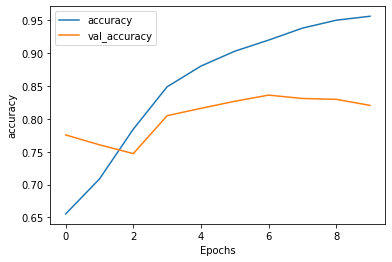

In [26]:
plot_graphs(blstm_history, 'accuracy')

#### Stack two or more LSTM layers
Keras recurrent layers have two available modes that are controlled by the **_return_sequences_** constructor argument:
- Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
- Return only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`).

In [27]:
blstm_2_model = Sequential([
    Embedding(tokenizer.vocab_size, 64),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [28]:
blstm_2_model.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [29]:
blstm_2_history = blstm_2_model.fit(train_dataset, epochs=10,
                           validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 213s 545ms/step - loss: 0.5654 - accuracy: 0.7074 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 204s 521ms/step - loss: 0.3755 - accuracy: 0.8485 - val_loss: 0.3967 - val_accuracy: 0.8375
Epoch 3/10
391/391 [==============================] - 207s 530ms/step - loss: 0.2817 - accuracy: 0.8906 - val_loss: 0.3920 - val_accuracy: 0.8444
Epoch 4/10
391/391 [==============================] - 206s 527ms/step - loss: 0.2403 - accuracy: 0.9085 - val_loss: 0.4351 - val_accuracy: 0.8357
Epoch 5/10
391/391 [==============================] - 208s 533ms/step - loss: 0.1964 - accuracy: 0.9280 - val_loss: 0.4857 - val_accuracy: 0.8284
Epoch 6/10
391/391 [==============================] - 209s 534ms/step - loss: 0.1507 - accuracy: 0.9470 - val_loss: 0.5565 - val_accuracy: 0.8031
Epoch 7/10
391/391 [==============================] - 208s 533ms/step - loss: 0.1199 - accuracy: 0.9595 - val_loss: 

In [30]:
blstm_2_model.save('blstm_2_model_10ep.h5')

In [31]:
test_loss, test_acc = blstm_2_model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 56s 144ms/step - loss: 0.6412 - accuracy: 0.6292
Test Loss: 0.641248063205758
Test Accuracy: 0.6292399764060974


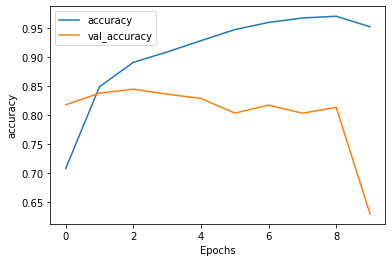

In [32]:
plot_graphs(blstm_2_history, 'accuracy')

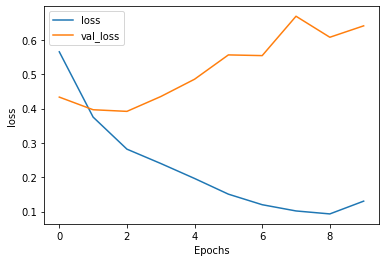

In [33]:
plot_graphs(blstm_2_history, 'loss')